# Survival Analysis

Mining Excavator dataset case study

In [36]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nestor
from nestor import keyword as kex
import nestor.datasets as dat
def set_style():
    # This sets reasonable defaults for font size for a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
set_style()

In [37]:
df = dat.load_excavators()
df.head()

,BscStartDate,Asset,OriginalShorttext,PMType,Cost
0,2004-07-01,A,BUCKET WON'T OPEN,PM01,183.05
1,2005-03-20,A,L/H BUCKET CYL LEAKING.,PM01,407.40
2,2006-05-05,A,SWAP BUCKET,PM01,0.00
3,2006-07-11,A,FIT BUCKET TOOTH,PM01,0.00
4,2006-11-10,A,REFIT BUCKET TOOTH,PM01,1157.27


## Knowledge Extraction
### Import vocabulary from tagging tool

In [39]:
# merge and cleanse NLP-containing columns of the data
nlp_select = kex.NLPSelect(columns = ['OriginalShorttext'])
raw_text = nlp_select.transform(df)

In [42]:
tex = kex.TokenExtractor()
toks = tex.fit_transform(raw_text)

#Import vocabulary
vocab_path = Path('.')/'support'/'mine_vocab_1g.csv'
vocab = kex.generate_vocabulary_df(tex, init=vocab_fname)
tag_df = kex.tag_extractor(tex, raw_text, vocab_df=vocab)

relation_df = tag_df.loc[:, ['P I', 'S I']]
tags_read = kex._get_readable_tag_df(tag_df)
tag_df = tag_df.loc[:, ['I', 'P', 'S', 'U', 'X', 'NA']]    

intialized successfully!
intialized successfully!


### Quality of Extracted Keywords

In [44]:
nbins = int(np.percentile(tag_df.sum(axis=1), 90))
print(f'Docs have at most {nbins} tokens (90th percentile)')


Docs have at most 5 tokens (90th percentile)


In [48]:
tags_read.join(df[['OriginalShorttext']]).sample(10)

,I,P,S,U,X,OriginalShorttext
3668,"oil, pressure, gauge",,,working,,Bottom R/H oil pressure gauge not workin
514,"bucket, grease, line",broken,,,,broken grease lines on bucket
1845,slew,,,,,No Slew
5133,"hose, hyd, stairs",damage,remount,acc,,ACC damage remount stair hyd hoses
1020,,,jump,start,,jump start x2
4829,horn,,replace,,,REPLACE HORN
4518,lube,"broken, damage, block",,"block, acc",,ACC DAMAGE- LUBE BLOCK BROKEN
982,"water, battery",,jump,start,,top up water in batteries and jump start
3496,timer,,,"working, idle",,Idle timer not working
1982,"oil, slew, cap, reservoir",missing,,,,OIL CAP MISSING ON R/H SLEW RESERVOIR


In [53]:
# how many instances of each keyword class are there?
print('named entities: ')
print('I\tItem\nP\tProblem\nS\tSolution')
print('U\tUnknown\nX\tStop Word')
print('total tokens: ', vocab.NE.notna().sum())
print('total tags: ', vocab.groupby("NE").nunique().alias.sum())
vocab.groupby("NE").nunique()

named entities: 
I	Item
P	Problem
S	Solution
U	Unknown
X	Stop Word
total tokens:  1767
total tags:  492


,NE,alias,notes,score
NE,,,,
,1,3,2,766
I,1,317,19,585
P,1,53,6,119
S,1,42,2,95
U,1,68,57,92
X,1,9,1,9


Tag completeness: 0.94 +/- 0.13
Complete Docs: 4444, or 81.02%
Empty Docs: 48, or 0.88%


/home/tbsexton/anaconda3/envs/nestor-dev/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'precision (PPV)')

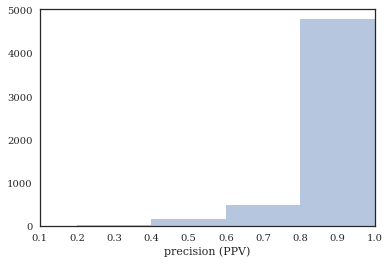

In [47]:
# tag-completeness of work-orders?
tag_pct, tag_comp, tag_empt = kex.get_tag_completeness(tag_df)

# with sns.axes_style('ticks') as style:
sns.distplot(tag_pct.dropna(), 
             kde=False, bins=nbins, 
             kde_kws={'cut':0})
plt.xlim(0.1, 1.0)
plt.xlabel('precision (PPV)')



## Survival Analysis

### Rules-Based
From Hodkeiwiz et al, a rule-based method was used to estimate failure times for SA. Let's see their data: 

In [31]:

df_clean = dat.load_excavators(cleaned=True)

df_clean['SuspSugg'] = pd.to_numeric(df_clean['SuspSugg'], errors='coerce')
df_clean.dropna(subset=['RunningTime', 'SuspSugg'], inplace=True)

df_clean.shape

(5288, 17)

In [32]:
df_clean.sort_values('BscStartDate').head(10)

,BscStartDate,Asset,OriginalShorttext,PMType,Cost,RunningTime,MajorSystem,Part,Action,Variant,FM,Location,Comments,FuncLocation,SuspSugg,Rule,Unnamed: 16
8,2001-07-19,B,REPLACE LIP,PM01,1251.52,7.0,Bucket,NaN,Replace,2V,NaN,NaN,NaN,Bucket,0.0,Rule_1_3_78_383_384,NaN
1820,2001-09-01,B,OIL LEAK L/H TRACK TENSIONER.,PM01,0.00,3.0,Hydraulic System,Track,Minor Maint,18,Leak,Left,NaN,Power Train - Transmission,0.0,Rule_1_3_52_289_347_425_500,NaN
1821,2001-09-04,B,BAD SOS METAL IN OIL,PM01,0.00,3.0,Hydraulic System,Slew Gearbox,NaN,NaN,Contamination,NaN,NaN,Sprocket/Drive Compartment Right,0.0,Rule_1_3_52_303_409,NaN
5253,2001-09-05,B,REPLACE AIRCONDITIONER BELTS,PM01,0.00,23.0,NaN,Air Conditioning,Replace,2V,NaN,NaN,NaN,Air Conditioning System,0.0,Rule_1_3_224_227_383_384,NaN
3701,2001-09-05,B,REPLACE CLAMPS ON CLAM PIPES,PM01,0.00,28.0,NaN,Mount,Replace,2V,NaN,NaN,NaN,Oil - Hydraulic,0.0,Rule_1_3_92_181_383_384,NaN
1167,2001-09-05,B,REPLACE RHS FAN BELT TENSIONER PULLEY,PM01,82.09,0.0,NaN,Fan,Minor Maint_Replace,2V,NaN,Right,NaN,+Cooling System,0.0,Rule_1_3_125_347_383_384_509,NaN
1168,2001-09-11,B,replace fan belt,PM01,0.00,6.0,NaN,Fan,Replace,2V,NaN,NaN,NaN,+Cooling System,0.0,Rule_1_3_125_383_384,NaN
644,2001-09-15,B,replace heads on lhs eng,PM01,0.00,33.0,Engine,NaN,Replace,2V,NaN,Left,NaN,Engine Left Cylinder Heads,0.0,Rule_1_3_25_383_384_499,NaN
4583,2001-09-26,B,REPAIR CABIN DOOR FALLING OFF.,PM01,0.00,27.0,NaN,Drivers Cabin,Repair,1,NaN,NaN,NaN,Operators Cabin,0.0,Rule_1_3_251_284_357,NaN
9,2001-10-01,B,rebuild lip #3,PM01,0.00,74.0,Bucket,NaN,Repair,5,NaN,NaN,NaN,Bucket Clam (Lip),0.0,Rule_1_3_78_362,NaN


0.060 0.833
transform: β=0.83	η=16.73


lambda_    0.06±0.0033
rho_        0.83±0.026
dtype: object

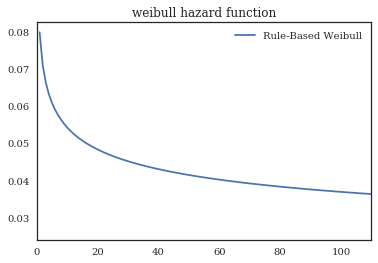

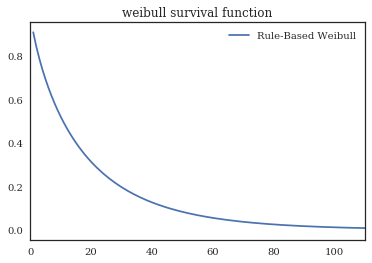

In [34]:
from lifelines import WeibullFitter, ExponentialFitter, KaplanMeierFitter
mask = (df_clean.MajorSystem =='Bucket')
# mask=df_clean.index
def mask_to_ETclean(df_clean, mask, fill_null=1.):
    filter_df = df_clean.loc[mask]
    g = filter_df.sort_values('BscStartDate').groupby('Asset')
    T = g['BscStartDate'].transform(pd.Series.diff).dt.days
#     T.loc[(T<=0.)|(T.isna())] = fill_null
    E = (~filter_df['SuspSugg'].astype(bool)).astype(int)
    return T.loc[~((T<=0.)|(T.isna()))], E.loc[~((T<=0.)|(T.isna()))]

T, E = mask_to_ETclean(df_clean, mask)
wf = WeibullFitter()
wf.fit(T, E, label='Rule-Based Weibull')
print('{:.3f}'.format(wf.lambda_), '{:.3f}'.format(wf.rho_))
# wf.print_summary()
wf.hazard_.plot()
plt.title('weibull hazard function')
plt.xlim(0,110)

wf.survival_function_.plot()
plt.xlim(0,110)
plt.title('weibull survival function')
print(f'transform: β={wf.rho_:.2f}\tη={1/wf.lambda_:.2f}')
# wf._compute_standard_errors()
to_bounds = lambda row:'±'.join([f'{i:.2g}' for i in row])
wf.summary.iloc[:,:2].apply(to_bounds, 1)

### Tag Based Comparison
We estimate the occurence of failures with tag occurrences. 

In [57]:
import math


def to_precision(x,p):
    """
    returns a string representation of x formatted with a precision of p

    Based on the webkit javascript implementation taken from here:
    https://code.google.com/p/webkit-mirror/source/browse/JavaScriptCore/kjs/number_object.cpp
    """

    x = float(x)

    if x == 0.:
        return "0." + "0"*(p-1)

    out = []

    if x < 0:
        out.append("-")
        x = -x

    e = int(math.log10(x))
    tens = math.pow(10, e - p + 1)
    n = math.floor(x/tens)

    if n < math.pow(10, p - 1):
        e = e -1
        tens = math.pow(10, e - p+1)
        n = math.floor(x / tens)

    if abs((n + 1.) * tens - x) <= abs(n * tens -x):
        n = n + 1

    if n >= math.pow(10,p):
        n = n / 10.
        e = e + 1

    m = "%.*g" % (p, n)

    if e < -2 or e >= p:
        out.append(m[0])
        if p > 1:
            out.append(".")
            out.extend(m[1:p])
        out.append('e')
        if e > 0:
            out.append("+")
        out.append(str(e))
    elif e == (p -1):
        out.append(m)
    elif e >= 0:
        out.append(m[:e+1])
        if e+1 < len(m):
            out.append(".")
            out.extend(m[e+1:])
    else:
        out.append("0.")
        out.extend(["0"]*-(e+1))
        out.append(m)

    return "".join(out)

def query_experiment(name, df, df_clean, rule, tag, multi_tag, prnt=False):
    
    def mask_to_ETclean(df_clean, mask, fill_null=1.):
        filter_df = df_clean.loc[mask]
        g = filter_df.sort_values('BscStartDate').groupby('Asset')
        T = g['BscStartDate'].transform(pd.Series.diff).dt.days
        E = (~filter_df['SuspSugg'].astype(bool)).astype(int)
        return T.loc[~((T<=0.)|(T.isna()))], E.loc[~((T<=0.)|(T.isna()))]
    
    def mask_to_ETraw(df_clean, mask, fill_null=1.):
        filter_df = df_clean.loc[mask]
        g = filter_df.sort_values('BscStartDate').groupby('Asset')
        T = g['BscStartDate'].transform(pd.Series.diff).dt.days
        T_defined = (T>0.)|T.notna()
        T = T[T_defined]
        # assume censored when parts replaced (changeout)
        E = (~(tag_df.S.changeout>0)).astype(int)[mask]
        E = E[T_defined]
        return T.loc[~((T<=0.)|(T.isna()))], E.loc[~((T<=0.)|(T.isna()))]
    
    experiment = {
        'rules-based': {
            'query': rule,
            'func': mask_to_ETclean,
            'mask': (df_clean.MajorSystem == rule),
            'data': df_clean
        },
        'single-tag': {
            'query': tag,
            'func': mask_to_ETraw,
            'mask': tag_df.I[tag].sum(axis=1)>0,
            'data': df
        },
        'multi-tag': {
            'query': multi_tag,
            'func': mask_to_ETraw,
            'mask': tag_df.I[multi_tag].sum(axis=1)>0,
            'data': df
        }
    }
    results = {
       ('query', 'text/tag'): [],
#        ('Weibull Params', r'$\lambda$'): [],
       ('Weibull Params', r'$\beta$'): [],
       ('Weibull Params', '$\eta$'): [],
       ('MTTF', 'Weib.'): [],
       ('MTTF', 'K-M'): []
       }
    idx = []
    
    for key, info in experiment.items():
        idx += [key]
        results[('query','text/tag')] += [info['query']]
        if prnt:
            print('{}: {}'.format(key, info['query']))
        info['T'], info['E'] = info['func'](info['data'], info['mask'])
        wf = WeibullFitter()
        wf.fit(info['T'], info['E'], label=f'{key} weibull')
        
        to_bounds = lambda row:'$\pm$'.join([to_precision(row[0],2),
                                             to_precision(row[1],1)])
        
        params = wf.summary.T.iloc[:2]
        params['eta_'] = [1/params.lambda_['coef'],  # err. propagation
                          (params.lambda_['se(coef)']/params.lambda_['coef']**2)]
        params = params.T.apply(to_bounds, 1)
        
        results[('Weibull Params', r'$\eta$')] += [params['eta_']]
        results[('Weibull Params', r'$\beta$')] += [params['rho_']]
        if prnt:                                     
            print('\tWeibull Params:\n',
                  '\t\tη = {}\t'.format(params['eta_']), 
                  'β = {}'.format(params['rho_']))
        
        kmf = KaplanMeierFitter()
        kmf.fit(info["T"], event_observed=info['E'], label=f'{key} kaplan-meier')
        results[('MTTF','Weib.')] += [to_precision(wf.median_,3)]
        results[('MTTF','K-M')] += [to_precision(kmf.median_,3)]
        if prnt:
            print(f'\tMTTF: \n\t\tWeib \t'+to_precision(wf.median_,3)+\
                   '\n\t\tKM \t'+to_precision(kmf.median_,3))
        info['kmf'] = kmf
        info['wf'] = wf
    return experiment, pd.DataFrame(results, index=pd.Index(idx, name=name))

In [58]:
bucket_exp, bucket_res = query_experiment('Bucket', df, df_clean,
                                          'Bucket',
                                          ['bucket'],
                                          ['bucket', 'tooth', 'lip', 'pin']);


In [59]:
tags = ['hyd', 'hose', 'pump', 'compressor']
hyd_exp, hyd_res = query_experiment('Hydraulic System', df, df_clean,
                                    'Hydraulic System',
                                    ['hyd'],
                                    tags)

In [60]:
eng_exp, eng_res = query_experiment('Engine', df, df_clean,
                                    'Engine',
                                    ['engine'],
                                    ['engine', 'filter', 'fan'])

In [61]:
frames = [bucket_res, hyd_res, eng_res]
res = pd.concat(frames, keys = [i.index.name for i in frames],
               names=['Major System', 'method'])
res

query Weibull Params  \
                                                   text/tag        $\beta$   
Major System     method                                                      
Bucket           rules-based                         Bucket  0.83$\pm$0.03   
                 single-tag                        [bucket]  0.83$\pm$0.03   
                 multi-tag        [bucket, tooth, lip, pin]  0.82$\pm$0.02   
Hydraulic System rules-based               Hydraulic System  0.86$\pm$0.02   
                 single-tag                           [hyd]  0.89$\pm$0.04   
                 multi-tag    [hyd, hose, pump, compressor]  0.89$\pm$0.02   
Engine           rules-based                         Engine  0.81$\pm$0.02   
                 single-tag                        [engine]  0.79$\pm$0.03   
                 multi-tag            [engine, filter, fan]  0.81$\pm$0.02   

                                          MTTF        
                                  $\eta$ Weib.   K-M  
Major System     method                               
Bucket           rules-based  17$\pm$0.9  10.8  9.00  
                 single-tag     27$\pm$2  17.1  15.0  
                 multi-tag    16$\pm$0.9  10.5  9.00  
Hydraulic System rules-based  14$\pm$0.6  9.07  8.00  
                 single-tag     36$\pm$3  24.1  25.0  
                 multi-tag    15$\pm$0.7  9.74  9.00  
Engine           rules-based    17$\pm$1  10.8  9.00  
                 single-tag     19$\pm$1  11.8  10.0  
                 multi-tag    15$\pm$0.8  9.31  8.00

/home/tbsexton/anaconda3/envs/nestor-dev/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


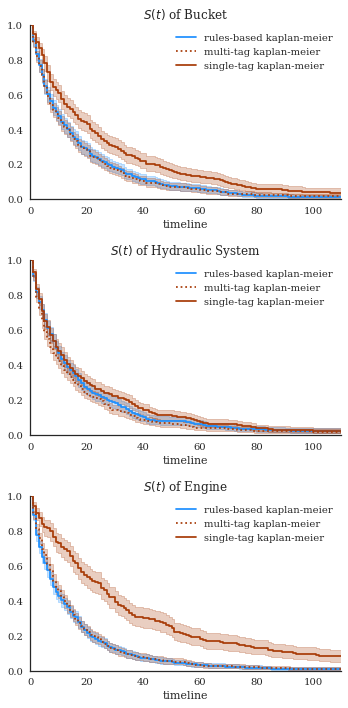

In [62]:

exp = [bucket_exp, eng_exp, hyd_exp]
f,axes = plt.subplots(nrows=3, figsize=(5,10))
for n, ax in enumerate(axes): 
    exp[n]['rules-based']['kmf'].plot(ax=ax, color='dodgerblue')
    exp[n]['multi-tag']['kmf'].plot(ax=ax, color='xkcd:rust', ls=':')
    exp[n]['single-tag']['kmf'].plot(ax=ax, color='xkcd:rust')
    
    ax.set_xlim(0,110)
    ax.set_ylim(0,1)
    ax.set_title(r"$S(t)$"+f" of {res.index.levels[0][n]}")
    sns.despine()
plt.tight_layout()
f.savefig('bkt_KMsurvival.png')   

This next one give you an idea of the differences better. using a log-transform. the tags under-estimate death rates a little in the 80-130 day range, probably because there's a failure mode not captured by the [bucket, lip, tooth] tags (because it's rare).

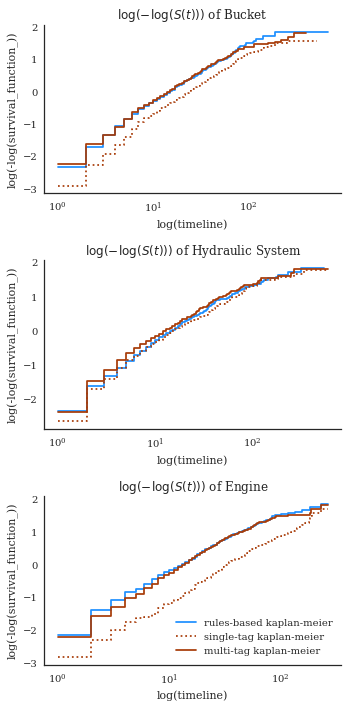

In [63]:
f,axes = plt.subplots(nrows=3, figsize=(5,10))
for n, ax in enumerate(axes): 
    exp[n]['rules-based']['kmf'].plot_loglogs(ax=ax, c='dodgerblue')
    exp[n]['single-tag']['kmf'].plot_loglogs(ax=ax, c='xkcd:rust', ls=':')
    exp[n]['multi-tag']['kmf'].plot_loglogs(ax=ax, c='xkcd:rust')
    if n != 2:
        ax.legend_.remove()
#     ax.set_xlim(0,110)
#     ax.set_ylim(0,1)
    ax.set_title(r"$\log(-\log(S(t)))$"+f" of {res.index.levels[0][n]}")
    sns.despine()
plt.tight_layout()
f.savefig('bkt_logKMsurvival.png')
# kmf.plot_loglogs()